In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%cd /content/drive/MyDrive/Code_Injection_Dataset

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/Code_Injection_Dataset'
e:\Work_DatPT\Study\Master\SecBERT


In [4]:
data_dir = 'E:\Work_DatPT\Study\Master'
df_train = pd.read_csv(data_dir+'\SecBERT\dataset_capec.csv')
df_train.head()

,text,label
0,GET /blog/index.php/2020/04/04/voluptatum-repr...,000 - Normal
1,GET /blog/xmlrpc.php?rsd,000 - Normal
2,GET /blog/index.php/2020/04/04/nihil-tenetur-e...,000 - Normal
3,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal
4,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal


label
66 - SQL Injection                        248093
000 - Normal                              226509
194 - Fake the Source of Data              55982
34 - HTTP Response Splitting               19134
126 - Path Traversal                       17595
242 - Code Injection                       13792
272 - Protocol Manipulation                 6924
310 - Scanning for Vulnerable Software      2382
153 - Input Data Manipulation               1387
Name: count, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '66 - SQL Injection'),
  Text(1, 0, '000 - Normal'),
  Text(2, 0, '194 - Fake the Source of Data'),
  Text(3, 0, '34 - HTTP Response Splitting'),
  Text(4, 0, '126 - Path Traversal'),
  Text(5, 0, '242 - Code Injection'),
  Text(6, 0, '272 - Protocol Manipulation'),
  Text(7, 0, '310 - Scanning for Vulnerable Software'),
  Text(8, 0, '153 - Input Data Manipulation')])

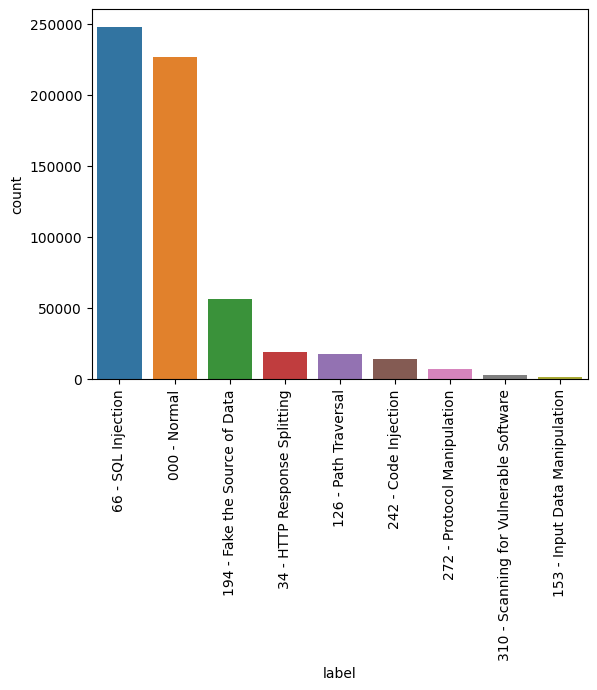

In [5]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_train['label'].value_counts()
print(x)
sns.barplot(x = x.index, y = x)
plt.xticks(rotation=90)

# Create Feature Extraction Module (BOW and TF-IDF)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import json


class Vectorizer:
    def __init__(self, method='BOW', ngram_range=(1, 1), max_features=300, emb_fname='', word_index_fname=''):
        self.method = method
        if self.method == 'BOW':
            self.vectorizer = CountVectorizer(analyzer='word', input='content', ngram_range=ngram_range, max_features=max_features)
        elif self.method == 'TFIDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', input='content', max_features=max_features)
        elif self.method == 'Word2Vec':
            self.max_features = max_features
            self.emb_fname = emb_fname
            self.word_index_fname = word_index_fname
        else:
            raise ValueError('Feature extraction method does not exist.')

    def feature_extraction(self, X_train, X_test):
        train_data = self.vectorizer.fit_transform(X_train).toarray()
        test_data = self.vectorizer.transform(X_test).toarray()
        return train_data, test_data

    def get_word_index(self):
        word2id = json.load(open(self.word_index_fname, 'r'))
        return word2id

    def get_embedding_matrix(self):
        np.random.seed(0)
        word2id = self.get_word_index()
        embedding_matrix = np.random.uniform(-0.25, 0.25, [len(word2id) + 1, self.max_features])
        with open(self.emb_fname, 'r', encoding='utf-8') as f:
            for line in f:
                content = line.split(' ')
                if content[0] in word2id:
                    embedding_matrix[word2id[content[0]]] = np.array(list(map(float, content[1:])))
        return embedding_matrix

In [7]:
# Optional (not effect very much)
df_train['text'] = df_train['text'].str.replace('/',' ')
df_train.head()

,text,label
0,GET blog index.php 2020 04 04 voluptatum-repr...,000 - Normal
1,GET blog xmlrpc.php?rsd,000 - Normal
2,GET blog index.php 2020 04 04 nihil-tenetur-e...,000 - Normal
3,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal
4,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal


# TF-IDF Feature Extraction

## Naive Bayes Classifier

In [8]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_val, y_train, y_val = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))




0.868012842176411


In [9]:
y_predict = mnb.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.81      0.93      0.86     45334
                  126 - Path Traversal       0.99      0.78      0.87      3435
         153 - Input Data Manipulation       0.11      1.00      0.19       285
         194 - Fake the Source of Data       0.98      0.91      0.94     11159
                  242 - Code Injection       0.97      0.91      0.94      2812
           272 - Protocol Manipulation       0.00      0.00      0.00      1381
310 - Scanning for Vulnerable Software       0.91      0.32      0.47       455
          34 - HTTP Response Splitting       0.95      0.93      0.94      3792
                    66 - SQL Injection       0.94      0.83      0.88     49707

                              accuracy                           0.87    118360
                             macro avg       0.74      0.73      0.68    118360
                          weighted avg

## Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.9591753970936127


In [11]:
y_predict = rf.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45334
                  126 - Path Traversal       1.00      0.92      0.96      3435
         153 - Input Data Manipulation       0.29      0.11      0.15       285
         194 - Fake the Source of Data       1.00      0.93      0.96     11159
                  242 - Code Injection       0.99      0.99      0.99      2812
           272 - Protocol Manipulation       0.65      0.12      0.20      1381
310 - Scanning for Vulnerable Software       0.86      0.98      0.91       455
          34 - HTTP Response Splitting       1.00      1.00      1.00      3792
                    66 - SQL Injection       0.98      0.96      0.97     49707

                              accuracy                           0.96    118360
                             macro avg       0.85      0.78      0.79    118360
                          weighted avg

## Decision Tree Classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini')
dt.fit(train_features, y_train)
print(dt.score(test_features, y_val))

0.9594457587022642


In [13]:
y_predict = dt.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45334
                  126 - Path Traversal       1.00      0.92      0.96      3435
         153 - Input Data Manipulation       0.75      0.02      0.04       285
         194 - Fake the Source of Data       1.00      0.93      0.96     11159
                  242 - Code Injection       0.99      0.99      0.99      2812
           272 - Protocol Manipulation       0.63      0.13      0.22      1381
310 - Scanning for Vulnerable Software       0.86      0.98      0.91       455
          34 - HTTP Response Splitting       1.00      1.00      1.00      3792
                    66 - SQL Injection       0.98      0.96      0.97     49707

                              accuracy                           0.96    118360
                             macro avg       0.90      0.77      0.78    118360
                          weighted avg

# AdaBoost Classifier

In [14]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=10)
abc.fit(train_features, y_train)
print(abc.score(test_features, y_val))

0.5630956404190605


In [15]:
y_predict = abc.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.00      0.00      0.00     45334
                  126 - Path Traversal       0.00      0.00      0.00      3435
         153 - Input Data Manipulation       0.00      0.00      0.00       285
         194 - Fake the Source of Data       0.99      0.93      0.96     11159
                  242 - Code Injection       1.00      0.97      0.98      2812
           272 - Protocol Manipulation       0.00      0.00      0.00      1381
310 - Scanning for Vulnerable Software       0.00      0.00      0.00       455
          34 - HTTP Response Splitting       1.00      1.00      1.00      3792
                    66 - SQL Injection       0.49      1.00      0.66     49707

                              accuracy                           0.56    118360
                             macro avg       0.39      0.43      0.40    118360
                          weighted avg

## Logistic Regression Classifier

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, y_train)
print(lr.score(test_features, y_val))


e:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9497296383913484


In [17]:
y_predict = lr.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.91      0.98      0.94     45334
                  126 - Path Traversal       0.98      0.90      0.94      3435
         153 - Input Data Manipulation       0.67      0.01      0.03       285
         194 - Fake the Source of Data       0.99      0.93      0.96     11159
                  242 - Code Injection       1.00      0.97      0.99      2812
           272 - Protocol Manipulation       0.00      0.00      0.00      1381
310 - Scanning for Vulnerable Software       0.83      0.93      0.88       455
          34 - HTTP Response Splitting       1.00      1.00      1.00      3792
                    66 - SQL Injection       0.98      0.95      0.96     49707

                              accuracy                           0.95    118360
                             macro avg       0.82      0.74      0.74    118360
                          weighted avg

# BOW Feature Extraction

## Naive Bayes Classifier

In [18]:
vectorizer = Vectorizer('BOW')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))

0.8273741128759716


In [19]:
y_predict = mnb.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.77      0.92      0.84     45334
                  126 - Path Traversal       0.99      0.89      0.94      3435
         153 - Input Data Manipulation       0.09      1.00      0.17       285
         194 - Fake the Source of Data       0.94      0.91      0.92     11159
                  242 - Code Injection       0.97      0.87      0.92      2812
           272 - Protocol Manipulation       0.04      0.08      0.05      1381
310 - Scanning for Vulnerable Software       0.81      0.40      0.53       455
          34 - HTTP Response Splitting       0.94      0.97      0.95      3792
                    66 - SQL Injection       0.96      0.73      0.83     49707

                              accuracy                           0.83    118360
                             macro avg       0.72      0.75      0.68    118360
                          weighted avg

## Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.9594288611017235


In [21]:
y_predict = rf.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45334
                  126 - Path Traversal       1.00      0.92      0.96      3435
         153 - Input Data Manipulation       0.75      0.02      0.04       285
         194 - Fake the Source of Data       1.00      0.93      0.96     11159
                  242 - Code Injection       0.99      0.99      0.99      2812
           272 - Protocol Manipulation       0.64      0.12      0.21      1381
310 - Scanning for Vulnerable Software       0.86      0.99      0.92       455
          34 - HTTP Response Splitting       1.00      1.00      1.00      3792
                    66 - SQL Injection       0.98      0.96      0.97     49707

                              accuracy                           0.96    118360
                             macro avg       0.90      0.77      0.78    118360
                          weighted avg

## Decision Tree Classifier

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini')
dt.fit(train_features, y_train)
print(dt.score(test_features, y_val))

0.9596992227103751


In [23]:
y_predict = dt.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45334
                  126 - Path Traversal       1.00      0.92      0.96      3435
         153 - Input Data Manipulation       0.75      0.02      0.04       285
         194 - Fake the Source of Data       1.00      0.93      0.96     11159
                  242 - Code Injection       0.99      0.99      0.99      2812
           272 - Protocol Manipulation       0.63      0.13      0.21      1381
310 - Scanning for Vulnerable Software       0.86      0.98      0.92       455
          34 - HTTP Response Splitting       1.00      1.00      1.00      3792
                    66 - SQL Injection       0.98      0.96      0.97     49707

                              accuracy                           0.96    118360
                             macro avg       0.90      0.77      0.78    118360
                          weighted avg

## AdaBoost Classifier

In [24]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=10)
abc.fit(train_features, y_train)
print(abc.score(test_features, y_val))

0.5630956404190605


In [25]:
y_predict = abc.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.00      0.00      0.00     45334
                  126 - Path Traversal       0.00      0.00      0.00      3435
         153 - Input Data Manipulation       0.00      0.00      0.00       285
         194 - Fake the Source of Data       0.99      0.93      0.96     11159
                  242 - Code Injection       1.00      0.97      0.98      2812
           272 - Protocol Manipulation       0.00      0.00      0.00      1381
310 - Scanning for Vulnerable Software       0.00      0.00      0.00       455
          34 - HTTP Response Splitting       1.00      1.00      1.00      3792
                    66 - SQL Injection       0.49      1.00      0.66     49707

                              accuracy                           0.56    118360
                             macro avg       0.39      0.43      0.40    118360
                          weighted avg

## Logistic Regression Classifier

In [26]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, y_train)
print(lr.score(test_features, y_val))

e:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.951495437647854


In [27]:
y_predict = lr.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.91      0.98      0.95     45334
                  126 - Path Traversal       1.00      0.92      0.96      3435
         153 - Input Data Manipulation       0.35      0.20      0.26       285
         194 - Fake the Source of Data       0.99      0.93      0.96     11159
                  242 - Code Injection       1.00      0.97      0.99      2812
           272 - Protocol Manipulation       0.22      0.00      0.00      1381
310 - Scanning for Vulnerable Software       0.84      0.96      0.90       455
          34 - HTTP Response Splitting       1.00      1.00      1.00      3792
                    66 - SQL Injection       0.98      0.95      0.97     49707

                              accuracy                           0.95    118360
                             macro avg       0.81      0.77      0.77    118360
                          weighted avg

# Word2Vec Feature Extraction

In [28]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)

In [30]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

In [31]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [32]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

e:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6186042581953363


In [33]:
y_predict = clf.predict(X_test)
print(classification_report(y_test,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_test, y_predict))

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.57      0.79      0.66     45111
                  126 - Path Traversal       0.41      0.08      0.14      3530
         153 - Input Data Manipulation       0.00      0.00      0.00       272
         194 - Fake the Source of Data       0.29      0.05      0.08     11287
                  242 - Code Injection       0.40      0.03      0.06      2814
           272 - Protocol Manipulation       0.00      0.00      0.00      1358
310 - Scanning for Vulnerable Software       0.71      0.91      0.80       510
          34 - HTTP Response Splitting       0.25      0.00      0.01      3842
                    66 - SQL Injection       0.69      0.73      0.71     49636

                              accuracy                           0.62    118360
                             macro avg       0.37      0.29      0.27    118360
                          weighted avg

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to a fixed length
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [36]:
## importing all libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Case 1 : Would use Word2Vec and then apply different classifiers
from gensim.models import Word2Vec  

## Case 2 : Would use TfidfVectorizer and then apply different classifiers
from sklearn.feature_extraction.text import TfidfVectorizer   

## This would help us understand : Does the type of Vectorizing Process influence the precision , accuracy , recall score of the classifiers ??


from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
# Classification using word2vec vectorizer
# Tokenize : dividing Sentences into words
df_train['text_clean'] = df_train['text'].apply(nltk.word_tokenize)
print('Tokenization complete.')

vec_model = Word2Vec(df_train['text_clean'])

w2v = dict(zip(vec_model.wv.index_to_key, vec_model.wv.vectors))
## What is syn0 ?
## https://stackoverflow.com/questions/53301916/python-gensim-what-is-the-meaning-of-syn0-and-syn0norm

class Vectorizer(object):
    
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])


## for any Classifier , we need intialise the model with the parameters. 
## Further I am applying GridSearchCV for 5 runs (i.e 1/5th data used each time for testing) 
## So the model gets trained over 5 runs 
## as well we are predicting also over 5 runs
## In case if you wish to know about Cross Validation , you can watch my Video here : https://www.youtube.com/watch?v=LmxsySwAhoE&t=84s
class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

    def fit(self, X, y):        
        return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)
    

## Preparing to make a pipeline 
clf_models = {
    'Naive Bayes': GaussianNB(), 
    'Decision Tree': DecisionTreeClassifier(),  
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

clf_params = {
    'Naive Bayes': { }, 
    'Decision Tree': { 'min_samples_split': [2, 5] }, 
    'Random Forest': { },
    'AdaBoost': {  }
}


## splitting the dataset into 80:20.  have kept shuffle=True , so that the data is randomly sampled or simply said shuffled , and then split.
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['label'], test_size=0.2, shuffle=True)

## for loop traverses , each and every classifier and its corresponding parameters.
for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec vectorizer', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    clf.fit(X_train, y_train)  ## Note : we are calling user defined fit method. This fit method uses Cross Validation
    y_pred = clf.predict(X_test)  ## Note : we are calling user defined predict method. This predict method uses Cross Validation
    
    ## printing performance metrics for each classifier 
    print(key, ':')
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    print('Confusion Matrix: \n',confusion_matrix(y_test, y_pred))

Tokenization complete.
Naive Bayes :
Accuracy: 0.475 	Precision: 0.359 	Recall: 0.632 		F1: 0.365

Confusion Matrix: 
 [[ 5340   822   579  4275   737 12852 12124  3646  5078]
 [   31  1619    27    62  1437   100   158    14    23]
 [    0     0   232    17     0     3    10     0     0]
 [  338   252   569  7518   245   921   453   822   112]
 [   34    66    14   219  2354     5     0    25    52]
 [  216     6    63    62     1   355   691     5    23]
 [    8     0     1     3     0    22   441     0     0]
 [  170     0   136   193     0    88    28  3137   114]
 [ 3384  1185   752  2671   740  2258  1024  2152 35246]]
Decision Tree :
Accuracy: 0.940 	Precision: 0.817 	Recall: 0.781 		F1: 0.795

Confusion Matrix: 
 [[43602    77    56   324    48   269    41    98   938]
 [  164  3238     6     7     7    14     7     2    26]
 [   61     6    87    27     0     5     0     0    76]
 [  880     8    51  9871    40    62     5    13   300]
 [   74     7     0    57  2563     0    

KeyboardInterrupt: 